# Profiling and Timing Code
In the process of developing code and creating data processing pipelines, there are
often trade-offs you can make between various implementations. Early in developing
your algorithm, it can be counterproductive to worry about such things. As Donald
Knuth famously quipped, “We should forget about small efficiencies, say about 97%
of the time: premature optimization is the root of all evil.”

But once you have your code working, it can be useful to dig into its efficiency a bit.
Sometimes it’s useful to check the execution time of a given command or set of com‐
mands; other times it’s useful to dig into a multiline process and determine where the
bottleneck lies in some complicated series of operations.

Python provides access to a
wide array of functionality for this kind of timing and profiling of code. Here we’ll
discuss the following IPython magic commands:

- %time
Time the execution of a single statement
- %timeit
Time repeated execution of a single statement for more accuracy
- %prun
Run code with the profiler
- %lprun
Run code with the line-by-line profiler
- %memit
Measure the memory use of a single statement
- %mprun
Run code with the line-by-line memory profiler

In [ ]:
%timeit sum(range(100))

1.19 µs ± 230 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Note that because this operation is so fast, %timeit automatically does a large number
of repetitions. For slower commands, %timeit will automatically adjust and perform
fewer repetitions:

In [ ]:
%%timeit
total = 0
for i in range(1000):
  for j in range(1000):
    total += i * (-1) ** j

513 ms ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Sometimes repeating an operation is not the best option. For example, if we have a
list that we’d like to sort, we might be misled by a repeated operation. Sorting a pre-
sorted list is much faster than sorting an unsorted list, so the repetition will skew the
result:

In [ ]:
import random
L = [random.random() for i in range(100000)]
%timeit L.sort()

1.02 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


For this, the %time magic function may be a better choice. It also is a good choice for
longer-running commands, when short, system-related delays are unlikely to affect
the result. Let’s time the sorting of an unsorted and a presorted list:

In [ ]:
import random
L = [random.random() for i in range(100000)]
print("sorting an unsorted list:")
%time L.sort()

sorting an unsorted list:
CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 23.1 ms


In [ ]:
print("sorting an already sorted list:")
%time L.sort()

sorting an already sorted list:
CPU times: user 3.05 ms, sys: 1 µs, total: 3.06 ms
Wall time: 3.15 ms


Notice how much faster the presorted list is to sort, but notice also how much longer
the timing takes with %time versus %timeit, even for the presorted list! This is a
result of the fact that %timeit does some clever things under the hood to prevent sys‐
tem calls from interfering with the timing. For example, it prevents cleanup of unused
Python objects (known as garbage collection) that might otherwise affect the timing.
For this reason, %timeit results are usually noticeably faster than %time results.
For %time as with %timeit, using the double-percent-sign cell-magic syntax allows
timing of multiline scripts:

In [ ]:
%%time
total = 0
for i in range(1000):
  for j in range(1000):
    total += i * (-1) ** j

CPU times: user 458 ms, sys: 0 ns, total: 458 ms
Wall time: 460 ms


# Profiling Full Scripts: %prun
A program is made of many single statements, and sometimes timing these statements in context is more important than timing them on their own. Python contains
a built-in code profiler (which you can read about in the Python documentation), but
IPython offers a much more convenient way to use this profiler, in the form of the
magic function %prun.
By way of example, we’ll define a simple function that does some calculations:

In [ ]:
def sum_of_lists(N):
  total = 0
  for i in range(5):
    L = [j ^ (j >> i) for j in range(N)]
    total += sum(L)
  return total

Now we can call %prun with a function call to see the profiled results:

In [ ]:
%prun sum_of_lists(1000000)

The result is a table that indicates, in order of total time on each function call, where
the execution is spending the most time. In this case, the bulk of execution time is in
the list comprehension inside sum_of_lists. From here, we could start thinking
about what changes we might make to improve the performance in the algorithm.

# Line-by-Line Profiling with %lprun
The function-by-function profiling of %prun is useful, but sometimes it’s more convenient to have a line-by-line profile report. This is not built into Python or IPython,
but there is a line_profiler package available for installation that can do this. Start by using Python’s packaging tool, pip, to install the line_profiler package:

In [ ]:
pip install line_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.4/709.4 kB 12.4 MB/s eta 0:00:00


In [ ]:
%load_ext line_profiler

Now the %lprun command will do a line-by-line profiling of any function—in this
case, we need to tell it explicitly which functions we’re interested in profiling:

In [ ]:
%lprun -f sum_of_lists sum_of_lists(5000)

The information at the top gives us the key to reading the results: the time is reported in microseconds and we can see where the program is spending the most time. At this point, we may be able to use this information to modify aspects of the script and make it perform better for our desired use case.

# Profiling Memory Use: %memit and %mprun
Another aspect of profiling is the amount of memory an operation uses. This can be evaluated with another IPython extension, the memory_profiler. As with the
line_profiler, we start by pip-installing the extension:

In [ ]:
pip install memory_profiler

In [ ]:
%load_ext memory_profiler

The memory profiler extension contains two useful magic functions: the %memit magic (which offers a memory-measuring equivalent of %timeit) and the %mprun
function (which offers a memory-measuring equivalent of %lprun). The %memit function can be used rather simply:

In [ ]:
%memit sum_of_lists(1000000)

peak memory: 175.73 MiB, increment: 71.73 MiB


We see that this function uses about 100 MB of memory.
For a line-by-line description of memory use, we can use the %mprun magic. Unfortu‐
nately, this magic works only for functions defined in separate modules rather than
the notebook itself, so we’ll start by using the %%file magic to create a simple module
called mprun_demo.py, which contains our sum_of_lists function, with one addition
that will make our memory profiling results more clear:

In [ ]:
%%file mprun_demo.py
def sum_of_lists(N):
  total = 0
  for i in range(5):
    L = [j ^ (j >> i) for j in range(N)]
    total += sum(L)
    del L # remove reference to L
  return total

Writing mprun_demo.py


We can now import the new version of this function and run the memory line
profiler:

In [ ]:
from mprun_demo import sum_of_lists
%mprun -f sum_of_lists sum_of_lists(100000)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/memory_profiler.py", line 847, in enable
    sys.settrace(self.trace_memory_usage)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/memory_profiler.py", line 850, in disable
    sys.settrace(self._original_trace_function)



Here the Increment column tells us how much each line affects the total memory
budget: observe that when we create and delete the list L, we are adding about 25 MB
of memory usage. This is on top of the background memory usage from the Python
interpreter itself

http://ipython.org
http://nbviewer.ipython.org/
http://github.com/ipython/ipython/wiki
https://github.com/jupyter/jupyter/wiki

# Using Pandas

In [ ]:
pip install pandas

In [ ]:
import pandas as pd
pd.__version__

'1.5.3'

# Introducing Pandas Objects
At the very basic level, Pandas objects can be thought of as enhanced versions of
NumPy structured arrays in which the rows and columns are identified with labels
rather than simple integer indices. As we will see during the course of this chapter,
Pandas provides a host of useful tools, methods, and functionality on top of the basic
data structures, but nearly everything that follows will require an understanding of
what these structures are. Thus, before we go any further, let’s introduce these three
fundamental Pandas data structures: the Series, DataFrame, and Index.


## The Pandas Series Object
A Pandas Series is a one-dimensional array of indexed data. It can be created from a list or array as follows:

In [ ]:
data = pd.Series([0.25, 0.5, 0.75, 1.0])
data

0    0.25
1    0.50
2    0.75
3    1.00
dtype: float64

As we see in the preceding output, the Series wraps both a sequence of values and a
sequence of indices, which we can access with the values and index attributes. The
values are simply a familiar NumPy array:

In [ ]:
data.values

array([0.25, 0.5 , 0.75, 1.  ])

The index is an array-like object of type pd.Index, which we’ll discuss in more detail momentarily:

In [ ]:
data.index

RangeIndex(start=0, stop=4, step=1)

Like with a NumPy array, data can be accessed by the associated index via the familiar Python square-bracket notation:

In [ ]:
data[1]

0.5

In [ ]:
data[1:3]

1    0.50
2    0.75
dtype: float64

## Series as generalized NumPy array
From what we’ve seen so far, it may look like the Series object is basically inter‐
changeable with a one-dimensional NumPy array. The essential difference is the pres‐
ence of the index: while the NumPy array has an implicitly defined integer index used
to access the values, the Pandas Series has an explicitly defined index associated with
the values.

This explicit index definition gives the Series object additional capabilities. For
example, the index need not be an integer, but can consist of values of any desired
type. For example, if we wish, we can use strings as an index:

In [ ]:
data = pd.Series([0.25, 0.5, 0.75, 1.0],
index=['a', 'b', 'c', 'd'])
data

a    0.25
b    0.50
c    0.75
d    1.00
dtype: float64

In [ ]:
data['b']

0.5

We can even use noncontiguous or nonsequential indices:

In [ ]:
data = pd.Series([0.25, 0.5, 0.75, 1.0],
index=[2, 5, 3, 7])
data

2    0.25
5    0.50
3    0.75
7    1.00
dtype: float64

In [ ]:
data[5]

0.5

## Series as specialized dictionary
In this way, you can think of a Pandas Series a bit like a specialization of a Python
dictionary. A dictionary is a structure that maps arbitrary keys to a set of arbitrary
values, and a Series is a structure that maps typed keys to a set of typed values. This
typing is important: just as the type-specific compiled code behind a NumPy array
makes it more efficient than a Python list for certain operations, the type information
of a Pandas Series makes it much more efficient than Python dictionaries for certain
operations.
We can make the Series-as-dictionary analogy even more clear by constructing a
Series object directly from a Python dictionary:

In [ ]:
population_dict = {'California': 38332521,
'Texas': 26448193,
'New York': 19651127,
'Florida': 19552860,
'Illinois': 12882135}
population = pd.Series(population_dict)
population

California    38332521
Texas         26448193
New York      19651127
Florida       19552860
Illinois      12882135
dtype: int64

By default, a Series will be created where the index is drawn from the sorted keys.
From here, typical dictionary-style item access can be performed:

In [ ]:
population['California']

38332521

Unlike a dictionary, though, the Series also supports array-style operations such as
slicing:

In [ ]:
population['California':'Illinois']

California    38332521
Texas         26448193
New York      19651127
Florida       19552860
Illinois      12882135
dtype: int64

# Constructing Series objects
We’ve already seen a few ways of constructing a Pandas Series from scratch; all of
them are some version of the following:
\>>> pd.Series(data, index=index)

where index is an optional argument, and data can be one of many entities.
For example, data can be a list or NumPy array, in which case index defaults to an
integer sequence:

In [ ]:
pd.Series([2, 4, 6])

0    2
1    4
2    6
dtype: int64

data can be a scalar, which is repeated to fill the specified index:

In [ ]:
pd.Series(5, index=[100, 200, 300])

100    5
200    5
300    5
dtype: int64

data can be a dictionary, in which index defaults to the sorted dictionary keys:

In [ ]:
pd.Series({2:'a', 1:'b', 3:'c'})

2    a
1    b
3    c
dtype: object

In each case, the index can be explicitly set if a different result is preferred:

In [ ]:
pd.Series({2:'a', 1:'b', 3:'c'}, index=[3, 2])

3    c
2    a
dtype: object

# The Pandas DataFrame Object
The next fundamental structure in Pandas is the DataFrame. Like the Series object
discussed in the previous section, the DataFrame can be thought of either as a gener‐
alization of a NumPy array, or as a specialization of a Python dictionary. We’ll now
take a look at each of these perspectives.

#DataFrame as a generalized NumPy array
If a Series is an analog of a one-dimensional array with flexible indices, a DataFrame
is an analog of a two-dimensional array with both flexible row indices and flexible
column names. Just as you might think of a two-dimensional array as an ordered
sequence of aligned one-dimensional columns, you can think of a DataFrame as a
sequence of aligned Series objects. Here, by “aligned” we mean that they share the
same index.

To demonstrate this, let’s first construct a new Series listing the area of each of the
five states discussed in the previous section:

In [ ]:
area_dict = {'California': 423967, 'Texas': 695662, 'New York': 141297,
'Florida': 170312, 'Illinois': 149995}
area = pd.Series(area_dict)
area

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
dtype: int64

Now that we have this along with the population Series from before, we can use a
dictionary to construct a single two-dimensional object containing this information:

In [ ]:
states = pd.DataFrame({'population': population,
'area': area})
states

,population,area
California,38332521,423967
Texas,26448193,695662
New York,19651127,141297
Florida,19552860,170312
Illinois,12882135,149995


Like the Series object, the DataFrame has an index attribute that gives access to the
index labels:

In [ ]:
states.index

Index(['California', 'Texas', 'New York', 'Florida', 'Illinois'], dtype='object')

Additionally, the DataFrame has a columns attribute, which is an Index object holding
the column labels:

In [ ]:
states.columns

Index(['population', 'area'], dtype='object')

## DataFrame as specialized dictionary
Similarly, we can also think of a DataFrame as a specialization of a dictionary. Where
a dictionary maps a key to a value, a DataFrame maps a column name to a Series of
column data. For example, asking for the 'area' attribute returns the Series object
containing the areas we saw earlier:

In [ ]:
states['area']

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
Name: area, dtype: int64

Notice the potential point of confusion here: in a two-dimensional NumPy array,
data[0] will return the first row. For a DataFrame, data['col0'] will return the first
column. Because of this, it is probably better to think about DataFrames as generalized
dictionaries rather than generalized arrays, though both ways of looking at the situa‐
tion can be useful.

## Constructing DataFrame objects
A Pandas DataFrame can be constructed in a variety of ways. Here we’ll give several
examples.

### From a single Series object.
A DataFrame is a collection of Series objects, and a single-column DataFrame can be constructed from a single Series:

In [ ]:
pd.DataFrame(population, columns=['population'])

,population
California,38332521
Texas,26448193
New York,19651127
Florida,19552860
Illinois,12882135


### From a list of dicts.
Any list of dictionaries can be made into a DataFrame. We’ll use a simple list comprehension to create some data:

In [ ]:
data = [{'a': i, 'b': 2 * i}
        for i in range(3)]
pd.DataFrame(data)

,a,b
0,0,0
1,1,2
2,2,4


Even if some keys in the dictionary are missing, Pandas will fill them in with NaN (i.e.,
“not a number”) values:

In [ ]:
pd.DataFrame([{'a': 1, 'b': 2}, {'b': 3, 'c': 4}])

,a,b,c
0,1.0,2,NaN
1,NaN,3,4.0


### From a dictionary of Series objects.
As we saw before, a DataFrame can be constructed
from a dictionary of Series objects as well:

In [ ]:
pd.DataFrame({'population': population,
'area': area})

,population,area
California,38332521,423967
Texas,26448193,695662
New York,19651127,141297
Florida,19552860,170312
Illinois,12882135,149995


### From a two-dimensional NumPy array.
Given a two-dimensional array of data, we can
create a DataFrame with any specified column and index names. If omitted, an integer
index will be used for each:

In [ ]:
import numpy as np
pd.DataFrame(np.random.rand(3, 2),
columns=['foo', 'bar'],
index=['a', 'b', 'c'])

,foo,bar
a,0.977100,0.105292
b,0.008463,0.440970
c,0.676238,0.272410


### From a NumPy structured array.
A Pandas DataFrame operates much like a
structured array, and can be created directly from one:

In [ ]:
A = np.zeros(3, dtype=[('A', 'i8'), ('B', 'f8')])
A

array([(0, 0.), (0, 0.), (0, 0.)], dtype=[('A', '<i8'), ('B', '<f8')])

In [ ]:
pd.DataFrame(A)

,A,B
0,0,0.0
1,0,0.0
2,0,0.0


# The Pandas Index Object:
We have seen here that both the Series and DataFrame objects contain an explicit
index that lets you reference and modify data. This Index object is an interesting
structure in itself, and it can be thought of either as an immutable array or as an
ordered set (technically a multiset, as Index objects may contain repeated values).
Those views have some interesting consequences in the operations available on Index
objects. As a simple example, let’s construct an Index from a list of integers:

In [ ]:
ind = pd.Index([2, 3, 5, 7, 11])
ind

Int64Index([2, 3, 5, 7, 11], dtype='int64')

## Index as immutable array
The Index object in many ways operates like an array. For example, we can use standard Python indexing notation to retrieve values or slices:

In [ ]:
ind[1]

3

In [ ]:
ind[::2]

Int64Index([2, 5, 11], dtype='int64')

Index objects also have many of the attributes familiar from NumPy arrays:

In [ ]:
print(ind.size, ind.shape, ind.ndim, ind.dtype)

5 (5,) 1 int64


One difference between Index objects and NumPy arrays is that indices are immuta‐
ble—that is, they cannot be modified via the normal means:

In [ ]:
ind[1] = 0

TypeError: ignored

## Index as ordered set
Pandas objects are designed to facilitate operations such as joins across datasets,
which depend on many aspects of set arithmetic. The Index object follows many of the conventions used by Python’s built-in set data structure, so that unions, intersections, differences, and other combinations can be computed in a familiar way

In [ ]:
indA = pd.Index([1, 3, 5, 7, 9])
indB = pd.Index([2, 3, 5, 7, 11])

In [ ]:
indA & indB # intersection

<ipython-input-52-f400ec9c4e08>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  indA & indB # intersection


Int64Index([3, 5, 7], dtype='int64')

In [ ]:
indA | indB # union

<ipython-input-53-0a17b8447828>:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  indA | indB # union


Int64Index([1, 2, 3, 5, 7, 9, 11], dtype='int64')

In [ ]:
indA ^ indB # symmetric difference

<ipython-input-54-aebc1839486a>:1: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  indA ^ indB # symmetric difference


Int64Index([1, 2, 9, 11], dtype='int64')

These operations may also be accessed via object methods—for example, indA.inter
section(indB).

# Data Indexing and Selection
Here we’ll look at similar means of
accessing and modifying values in Pandas Series and DataFrame objects. If you have
used the NumPy patterns, the corresponding patterns in Pandas will feel very familiar, though there are a few quirks to be aware of.

We’ll start with the simple case of the one-dimensional Series object, and then move
on to the more complicated two-dimensional DataFrame object.

## Data Selection in Series
As we saw in the previous section, a Series object acts in many ways like a one dimensional NumPy array, and in many ways like a standard Python dictionary. If we keep these two overlapping analogies in mind, it will help us to understand the patterns of data indexing and selection in these arrays.

### Series as dictionary
Like a dictionary, the Series object provides a mapping from a collection of keys to a
collection of values:

In [ ]:
data = pd.Series([0.25, 0.5, 0.75, 1.0],
index=['a', 'b', 'c', 'd'])
data

a    0.25
b    0.50
c    0.75
d    1.00
dtype: float64

In [ ]:
data['b']

0.5

We can also use dictionary-like Python expressions and methods to examine the
keys/indices and values:

In [ ]:
'a' in data

True

In [ ]:
data.keys()

Index(['a', 'b', 'c', 'd'], dtype='object')

In [ ]:
list(data.items())

[('a', 0.25), ('b', 0.5), ('c', 0.75), ('d', 1.0)]

Series objects can even be modified with a dictionary-like syntax. Just as you can
extend a dictionary by assigning to a new key, you can extend a Series by assigning
to a new index value:

In [ ]:
data['e'] = 1.25
data

a    0.25
b    0.50
c    0.75
d    1.00
e    1.25
dtype: float64

This easy mutability of the objects is a convenient feature: under the hood, Pandas is
making decisions about memory layout and data copying that might need to take
place; the user generally does not need to worry about these issues.

# Series as one-dimensional array
A Series builds on this dictionary-like interface and provides array-style item selec‐
tion via the same basic mechanisms as NumPy arrays—that is, slices, masking, and
fancy indexing. Examples of these are as follows:


In [ ]:
# slicing by explicit index
data['a':'c']

a    0.25
b    0.50
c    0.75
dtype: float64

In [ ]:
# slicing by implicit integer index
data[0:2]

a    0.25
b    0.50
dtype: float64

In [ ]:
# masking
data[(data > 0.3) & (data < 0.8)]

b    0.50
c    0.75
dtype: float64

In [ ]:
# fancy indexing
data[['a', 'e']]

a    0.25
e    1.25
dtype: float64

Among these, slicing may be the source of the most confusion. Notice that when you
are slicing with an explicit index (i.e., data['a':'c']), the final index is included in
the slice, while when you’re slicing with an implicit index (i.e., data[0:2]), the final
index is excluded from the slice.

### Indexers: loc, iloc, and ix
These slicing and indexing conventions can be a source of confusion. For example, if
your Series has an explicit integer index, an indexing operation such as data[1] will
use the explicit indices, while a slicing operation like data[1:3] will use the implicit
Python-style index.

In [ ]:
data = pd.Series(['a', 'b', 'c'], index=[1, 3, 5])
data

1    a
3    b
5    c
dtype: object

In [ ]:
# explicit index when indexing
data[1]

'a'

In [ ]:
# implicit index when slicing
data[1:3]

3    b
5    c
dtype: object

Because of this potential confusion in the case of integer indexes, Pandas provides
some special indexer attributes that explicitly expose certain indexing schemes. These are not functional methods, but attributes that expose a particular slicing interface to
the data in the Series.

First, the loc attribute allows indexing and slicing that always references the explicit
index:

In [ ]:
data.loc[1]

'a'

In [ ]:
data.loc[1:3]

1    a
3    b
dtype: object

The iloc attribute allows indexing and slicing that always references the implicit
Python-style index:

In [ ]:
data.iloc[1]

'b'

In [ ]:
data.iloc[1:3]

3    b
5    c
dtype: object

A third indexing attribute, ix, is a hybrid of the two, and for Series objects is equiva‐
lent to standard []-based indexing. The purpose of the ix indexer will become more
apparent in the context of DataFrame objects, which we will discuss in a moment.


One guiding principle of Python code is that “explicit is better than implicit.” The
explicit nature of loc and iloc make them very useful in maintaining clean and read‐
able code; especially in the case of integer indexes, I recommend using these both to
make code easier to read and understand, and to prevent subtle bugs due to the
mixed indexing/slicing convention.

In [ ]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


# Data Selection in DataFrame
Recall that a DataFrame acts in many ways like a two-dimensional or structured array,
and in other ways like a dictionary of Series structures sharing the same index.
These analogies can be helpful to keep in mind as we explore data selection within
this structure.

## DataFrame as a dictionary
The first analogy we will consider is the DataFrame as a dictionary of related Series
objects. Let’s return to our example of areas and populations of states:

In [ ]:
area = pd.Series({'California': 423967, 'Texas': 695662,
'New York': 141297, 'Florida': 170312,
'Illinois': 149995})
pop = pd.Series({'California': 38332521, 'Texas': 26448193,
'New York': 19651127, 'Florida': 19552860,
'Illinois': 12882135})
data = pd.DataFrame({'area':area, 'pop':pop})
data

,area,pop
California,423967,38332521
Texas,695662,26448193
New York,141297,19651127
Florida,170312,19552860
Illinois,149995,12882135


The individual Series that make up the columns of the DataFrame can be accessed
via dictionary-style indexing of the column name:

In [ ]:
data['area']

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
Name: area, dtype: int64

In [ ]:
data.area

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
Name: area, dtype: int64

This attribute-style column access actually accesses the exact same object as the
dictionary-style access:

In [ ]:
data.area is data['area']

True

Though this is a useful shorthand, keep in mind that it does not work for all cases!
For example, if the column names are not strings, or if the column names conflict
with methods of the DataFrame, this attribute-style access is not possible. For exam‐
ple, the DataFrame has a pop() method, so data.pop will point to this rather than the
"pop" column:

In [ ]:
data.pop is data['pop']

False

In particular, you should avoid the temptation to try column assignment via attribute
(i.e., use data['pop'] = z rather than data.pop = z).
Like with the Series objects discussed earlier, this dictionary-style syntax can also be
used to modify the object, in this case to add a new column:

In [ ]:
data['density'] = data['pop'] / data['area']
data

,area,pop,density
California,423967,38332521,90.413926
Texas,695662,26448193,38.018740
New York,141297,19651127,139.076746
Florida,170312,19552860,114.806121
Illinois,149995,12882135,85.883763


## DataFrame as two-dimensional array
As mentioned previously, we can also view the DataFrame as an enhanced two-
dimensional array. We can examine the raw underlying data array using the values
attribute:

In [ ]:
data.values

array([[4.23967000e+05, 3.83325210e+07, 9.04139261e+01],
       [6.95662000e+05, 2.64481930e+07, 3.80187404e+01],
       [1.41297000e+05, 1.96511270e+07, 1.39076746e+02],
       [1.70312000e+05, 1.95528600e+07, 1.14806121e+02],
       [1.49995000e+05, 1.28821350e+07, 8.58837628e+01]])

With this picture in mind, we can do many familiar array-like observations on the
DataFrame itself. For example, we can transpose the full DataFrame to swap rows and
columns:

In [ ]:
data.T

,California,Texas,New York,Florida,Illinois
area,4.239670e+05,6.956620e+05,1.412970e+05,1.703120e+05,1.499950e+05
pop,3.833252e+07,2.644819e+07,1.965113e+07,1.955286e+07,1.288214e+07
density,9.041393e+01,3.801874e+01,1.390767e+02,1.148061e+02,8.588376e+01


When it comes to indexing of DataFrame objects, however, it is clear that the dictionary-style indexing of columns precludes our ability to simply treat it as a
NumPy array. In particular, passing a single index to an array accesses a row:

In [ ]:
data.values[0]

array([4.23967000e+05, 3.83325210e+07, 9.04139261e+01])

and passing a single “index” to a DataFrame accesses a column:

In [ ]:
data['area']

California    423967
Texas         695662
New York      141297
Florida       170312
Illinois      149995
Name: area, dtype: int64

Thus for array-style indexing, we need another convention. Here Pandas again uses
the loc, iloc, and ix indexers mentioned earlier. Using the iloc indexer, we can
index the underlying array as if it is a simple NumPy array (using the implicit
Python-style index), but the DataFrame index and column labels are maintained in
the result:

In [ ]:
data.iloc[:3, :2]

,area,pop
California,423967,38332521
Texas,695662,26448193
New York,141297,19651127


In [ ]:
data.loc[:'Illinois', :'pop']

,area,pop
California,423967,38332521
Texas,695662,26448193
New York,141297,19651127
Florida,170312,19552860
Illinois,149995,12882135


Any of the familiar NumPy-style data access patterns can be used within these index‐
ers. For example, in the loc indexer we can combine masking and fancy indexing as
in the following:

In [ ]:
data.loc[data.density > 100, ['pop', 'density']]

,pop,density
New York,19651127,139.076746
Florida,19552860,114.806121


Any of these indexing conventions may also be used to set or modify values; this is
done in the standard way that you might be accustomed to from working with
NumPy:

In [ ]:
data.iloc[0, 2] = 90
data

,area,pop,density
California,423967,38332521,90.000000
Texas,695662,26448193,38.018740
New York,141297,19651127,139.076746
Florida,170312,19552860,114.806121
Illinois,149995,12882135,85.883763


Additional indexing conventions
There are a couple extra indexing conventions that might seem at odds with the pre‐
ceding discussion, but nevertheless can be very useful in practice. First, while index‐
ing refers to columns, slicing refers to rows:

In [ ]:
data['Florida':'Illinois']

,area,pop,density
Florida,170312,19552860,114.806121
Illinois,149995,12882135,85.883763


Such slices can also refer to rows by number rather than by index:

In [ ]:
data[1:3]

,area,pop,density
Texas,695662,26448193,38.018740
New York,141297,19651127,139.076746


Similarly, direct masking operations are also interpreted row-wise rather than
column-wise:

In [ ]:
data[data.density > 100]

,area,pop,density
New York,141297,19651127,139.076746
Florida,170312,19552860,114.806121


# Handling Missing Data
The difference between data found in many tutorials and data in the real world is that
real-world data is rarely clean and homogeneous. In particular, many interesting
datasets will have some amount of data missing. To make matters even more compli‐
cated, different data sources may indicate missing data in different ways.

In this section, we will discuss some general considerations for missing data, discuss
how Pandas chooses to represent it, and demonstrate some built-in Pandas tools for
handling missing data in Python. Here and throughout the book, we’ll refer to miss‐
ing data in general as null, NaN, or NA values.

## Trade-Offs in Missing Data Conventions
A number of schemes have been developed to indicate the presence of missing data in
a table or DataFrame. Generally, they revolve around one of two strategies: using a
mask that globally indicates missing values, or choosing a sentinel value that indicates
a missing entry.

In the masking approach, the mask might be an entirely separate Boolean array, or it
may involve appropriation of one bit in the data representation to locally indicate the
null status of a value.

In the sentinel approach, the sentinel value could be some data-specific convention,
such as indicating a missing integer value with –9999 or some rare bit pattern, or it
could be a more global convention, such as indicating a missing floating-point value
with NaN (Not a Number), a special value which is part of the IEEE floating-point
specification.

None of these approaches is without trade-offs: use of a separate mask array requires
allocation of an additional Boolean array, which adds overhead in both storage and
computation. A sentinel value reduces the range of valid values that can be repre‐
sented, and may require extra (often non-optimized) logic in CPU and GPU arith‐
metic. Common special values like NaN are not available for all data types.

As in most cases where no universally optimal choice exists, different languages and
systems use different conventions. For example, the R language uses reserved bit patterns within each data type as sentinel values indicating missing data, while the SciDB
system uses an extra byte attached to every cell to indicate a NA state.

## Missing Data in Pandas
The way in which Pandas handles missing values is constrained by its reliance on the
NumPy package, which does not have a built-in notion of NA values for non-
floating-point data types.

Pandas could have followed R’s lead in specifying bit patterns for each individual data
type to indicate nullness, but this approach turns out to be rather unwieldy. While R
contains four basic data types, NumPy supports far more than this: for example,
while R has a single integer type, NumPy supports fourteen basic integer types once
you account for available precisions, signedness, and endianness of the encoding.

Reserving a specific bit pattern in all available NumPy types would lead to an
unwieldy amount of overhead in special-casing various operations for various types, likely even requiring a new fork of the NumPy package. Further, for the smaller data
types (such as 8-bit integers), sacrificing a bit to use as a mask will significantly
reduce the range of values it can represent.
NumPy does have support for masked arrays—that is, arrays that have a separate

Boolean mask array attached for marking data as “good” or “bad.” Pandas could have
derived from this, but the overhead in both storage, computation, and code mainte‐
nance makes that an unattractive choice.
With these constraints in mind, Pandas chose to use sentinels for missing data, and
further chose to use two already-existing Python null values: the special floating-
point NaN value, and the Python None object. This choice has some side effects, as we
will see, but in practice ends up being a good compromise in most cases of interest.

## None: Pythonic missing data
The first sentinel value used by Pandas is None, a Python singleton object that is often
used for missing data in Python code. Because None is a Python object, it cannot be
used in any arbitrary NumPy/Pandas array, but only in arrays with data type
'object' (i.e., arrays of Python objects):

In [ ]:
vals1 = np.array([1, None, 3, 4])
vals1

array([1, None, 3, 4], dtype=object)

This dtype=object means that the best common type representation NumPy could
infer for the contents of the array is that they are Python objects. While this kind of
object array is useful for some purposes, any operations on the data will be done at
the Python level, with much more overhead than the typically fast operations seen for
arrays with native types:

In [ ]:
for dtype in ['object', 'int']:
  print("dtype =", dtype)
  %timeit np.arange(1E6, dtype=dtype).sum()
  print()

dtype = object
10 loops, best of 5: 72.5 ms per loop

dtype = int
1000 loops, best of 5: 1.68 ms per loop



The use of Python objects in an array also means that if you perform aggregations
like sum() or min() across an array with a None value, you will generally get an error:

In [ ]:
vals1.sum()

TypeError: ignored

This reflects the fact that addition between an integer and None is undefined.
## NaN: Missing numerical data
The other missing data representation, NaN (acronym for Not a Number), is different;
it is a special floating-point value recognized by all systems that use the standard
IEEE floating-point representation:

In [ ]:
vals2 = np.array([1, np.nan, 3, 4])
vals2.dtype

dtype('float64')

Notice that NumPy chose a native floating-point type for this array: this means that
unlike the object array from before, this array supports fast operations pushed into
compiled code. You should be aware that NaN is a bit like a data virus—it infects any
other object it touches. Regardless of the operation, the result of arithmetic with NaN
will be another NaN:

In [ ]:
1 + np.nan

nan

In [ ]:
0 * np.nan

nan

Note that this means that aggregates over the values are well defined (i.e., they don’t
result in an error) but not always useful:

In [ ]:
vals2.sum(), vals2.min(), vals2.max()

(nan, nan, nan)

NumPy does provide some special aggregations that will ignore these missing values:

In [ ]:
np.nansum(vals2), np.nanmin(vals2), np.nanmax(vals2)

(8.0, 1.0, 4.0)

Keep in mind that NaN is specifically a floating-point value; there is no equivalent
NaN value for integers, strings, or other types.
## NaN and None in Pandas
NaN and None both have their place, and Pandas is built to handle the two of them
nearly interchangeably, converting between them where appropriate:

In [ ]:
pd.Series([1, np.nan, 2, None])

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

For types that don’t have an available sentinel value, Pandas automatically type-casts
when NA values are present. For example, if we set a value in an integer array to
np.nan, it will automatically be upcast to a floating-point type to accommodate the
NA:

In [ ]:
x = pd.Series(range(2), dtype=int)
x

0    0
1    1
dtype: int64

In [ ]:
x[0] = None
x

0    NaN
1    1.0
dtype: float64

While this type of magic may feel a bit hackish compared to the more unified
approach to NA values in domain-specific languages like R, the Pandas sentinel/casting approach works quite well in practice and in my experience only rarely causes
issues.

## Operating on Null Values
As we have seen, Pandas treats None and NaN as essentially interchangeable for indi‐
cating missing or null values. To facilitate this convention, there are several useful
methods for detecting, removing, and replacing null values in Pandas data structures.
They are:

- isnull()
Generate a Boolean mask indicating missing values
- notnull()
Opposite of isnull()
- dropna()
Return a filtered version of the data
- fillna()
Return a copy of the data with missing values filled or imputed

We will conclude this section with a brief exploration and demonstration of these
routines.

Detecting null values
Pandas data structures have two useful methods for detecting null data: isnull() and
notnull(). Either one will return a Boolean mask over the data. For example:

In [ ]:
data = pd.Series([1, np.nan, 'hello', None])
data.isnull()

0    False
1     True
2    False
3     True
dtype: bool

Boolean masks can be
used directly as a Series or DataFrame index:

In [ ]:
data[data.notnull()]

0        1
2    hello
dtype: object

The isnull() and notnull() methods produce similar Boolean results for Data
Frames.
## Dropping null values
In addition to the masking used before, there are the convenience methods, dropna()
(which removes NA values) and fillna() (which fills in NA values). For a Series,
the result is straightforward:

In [ ]:
data.dropna()

0        1
2    hello
dtype: object

For a DataFrame, there are more options. Consider the following DataFrame:

In [ ]:
df = pd.DataFrame([[1,       np.nan,  2],
                   [2,       3,       5],
                   [np.nan,  4,       6]])
df

,0,1,2
0,1.0,NaN,2
1,2.0,3.0,5
2,NaN,4.0,6


We cannot drop single values from a DataFrame; we can only drop full rows or full
columns. Depending on the application, you might want one or the other, so
dropna() gives a number of options for a DataFrame.
By default, dropna() will drop all rows in which any null value is present:

In [ ]:
df.dropna()

,0,1,2
1,2.0,3.0,5


Alternatively, you can drop NA values along a different axis; axis=1 drops all col‐
umns containing a null value:

In [ ]:
df.dropna(axis='columns')

,2
0,2
1,5
2,6


But this drops some good data as well; you might rather be interested in dropping
rows or columns with all NA values, or a majority of NA values. This can be specified
through the how or thresh parameters, which allow fine control of the number of
nulls to allow through.

The default is how='any', such that any row or column (depending on the axis key‐
word) containing a null value will be dropped. You can also specify how='all', which
will only drop rows/columns that are all null values:

In [ ]:
df[3] = np.nan
df

,0,1,2,3
0,1.0,NaN,2,NaN
1,2.0,3.0,5,NaN
2,NaN,4.0,6,NaN


In [ ]:
df.dropna(axis='columns', how='all')

,0,1,2
0,1.0,NaN,2
1,2.0,3.0,5
2,NaN,4.0,6


For finer-grained control, the thresh parameter lets you specify a minimum number
of non-null values for the row/column to be kept:

In [ ]:
df.dropna(axis='rows', thresh=3)

,0,1,2,3
1,2.0,3.0,5,NaN


Here the first and last row have been dropped, because they contain only two non-
null values.

## Filling null values
Sometimes rather than dropping NA values, you’d rather replace them with a valid
value. This value might be a single number like zero, or it might be some sort of
imputation or interpolation from the good values. You could do this in-place using
the isnull() method as a mask, but because it is such a common operation Pandas
provides the fillna() method, which returns a copy of the array with the null values
replaced.

Consider the following Series:

In [ ]:
data = pd.Series([1, np.nan, 2, None, 3], index=list('abcde'))
data

a    1.0
b    NaN
c    2.0
d    NaN
e    3.0
dtype: float64

We can fill NA entries with a single value, such as zero:

In [ ]:
data.fillna(0)

a    1.0
b    0.0
c    2.0
d    0.0
e    3.0
dtype: float64

We can specify a forward-fill to propagate the previous value forward:

In [ ]:
# forward-fill
data.fillna(method='ffill')

a    1.0
b    1.0
c    2.0
d    2.0
e    3.0
dtype: float64

Or we can specify a back-fill to propagate the next values backward:

In [ ]:
# back-fill
data.fillna(method='bfill')

a    1.0
b    2.0
c    2.0
d    3.0
e    3.0
dtype: float64

For DataFrames, the options are similar, but we can also specify an axis along which
the fills take place:

In [ ]:
df

,0,1,2,3
0,1.0,NaN,2,NaN
1,2.0,3.0,5,NaN
2,NaN,4.0,6,NaN


In [ ]:
df.fillna(method='ffill', axis=1)

,0,1,2,3
0,1.0,1.0,2.0,2.0
1,2.0,3.0,5.0,5.0
2,NaN,4.0,6.0,6.0


Notice that if a previous value is not available during a forward fill, the NA value
remains.

# Combining Datasets: Concat and Append
Some of the most interesting studies of data come from combining different data
sources. These operations can involve anything from very straightforward concatenation of two different datasets, to more complicated database-style joins and merges
that correctly handle any overlaps between the datasets. Series and DataFrames are
built with this type of operation in mind, and Pandas includes functions and methods
that make this sort of data wrangling fast and straightforward.

Here we’ll take a look at simple concatenation of Series and DataFrames with the
pd.concat function; later we’ll dive into more sophisticated in-memory merges and
joins implemented in Pandas.

In [ ]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    data = {c: [str(c) + str(i) for i in ind]
            for c in cols}
    return pd.DataFrame(data, ind)
# example DataFrame
make_df('ABC', range(3))

,A,B,C
0,A0,B0,C0
1,A1,B1,C1
2,A2,B2,C2


# Combining Datasets: Merge and Join
One essential feature offered by Pandas is its high-performance, in-memory join and
merge operations. If you have ever worked with databases, you should be familiar
with this type of data interaction. The main interface for this is the pd.merge function, and we’ll see a few examples of how this can work in practice.

## Relational Algebra
The behavior implemented in pd.merge() is a subset of what is known as relational
algebra, which is a formal set of rules for manipulating relational data, and forms the
conceptual foundation of operations available in most databases. The strength of the relational algebra approach is that it proposes several primitive operations, which
become the building blocks of more complicated operations on any dataset. With this
lexicon of fundamental operations implemented efficiently in a database or other pro‐
gram, a wide range of fairly complicated composite operations can be performed.

Pandas implements several of these fundamental building blocks in the pd.merge()
function and the related join() method of Series and DataFrames. As we will see,
these let you efficiently link data from different sources.

## Categories of Joins
The pd.merge() function implements a number of types of joins: the one-to-one,
many-to-one, and many-to-many joins. All three types of joins are accessed via an
identical call to the pd.merge() interface; the type of join performed depends on the
form of the input data. Here we will show simple examples of the three types of
merges, and discuss detailed options further below.

### One-to-one joins
Perhaps the simplest type of merge expression is the one-to-one join, which is in
many ways very similar to the column-wise concatenation. consider the following
two DataFrames, which contain information on several employees in a company:

In [ ]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
'group': ['Accounting', 'Engineering', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
'hire_date': [2004, 2008, 2012, 2014]})
print(df1); print(df2)

  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014


To combine this information into a single DataFrame, we can use the pd.merge()
function:

In [ ]:
df3 = pd.merge(df1, df2)
df3

,employee,group,hire_date
0,Bob,Accounting,2008
1,Jake,Engineering,2012
2,Lisa,Engineering,2004
3,Sue,HR,2014


The pd.merge() function recognizes that each DataFrame has an “employee” column,
and automatically joins using this column as a key. The result of the merge is a new
DataFrame that combines the information from the two inputs. Notice that the order
of entries in each column is not necessarily maintained: in this case, the order of the
“employee” column differs between df1 and df2, and the pd.merge() function cor‐
rectly accounts for this. Additionally, keep in mind that the merge in general discards
the index, except in the special case of merges by index

### Many-to-one joins
Many-to-one joins are joins in which one of the two key columns contains duplicate
entries. For the many-to-one case, the resulting DataFrame will preserve those dupli‐
cate entries as appropriate. Consider the following example of a many-to-one join:

In [ ]:
df4 = pd.DataFrame({'group': ['Accounting', 'Engineering', 'HR'],
'supervisor': ['Carly', 'Guido', 'Steve']})
print(df3); print(df4); print(pd.merge(df3, df4))

  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014
         group supervisor
0   Accounting      Carly
1  Engineering      Guido
2           HR      Steve
  employee        group  hire_date supervisor
0      Bob   Accounting       2008      Carly
1     Jake  Engineering       2012      Guido
2     Lisa  Engineering       2004      Guido
3      Sue           HR       2014      Steve


The resulting DataFrame has an additional column with the “supervisor” information,
where the information is repeated in one or more locations as required by the inputs.
### Many-to-many joins
Many-to-many joins are a bit confusing conceptually, but are nevertheless well
defined. If the key column in both the left and right array contains duplicates, then
the result is a many-to-many merge. This will be perhaps most clear with a concrete
example. Consider the following, where we have a DataFrame showing one or more
skills associated with a particular group.
By performing a many-to-many join, we can recover the skills associated with any
individual person:

In [ ]:
df5 = pd.DataFrame({'group': ['Accounting', 'Accounting',
'Engineering', 'Engineering', 'HR', 'HR'], 'skills': ['math', 'spreadsheets', 'coding', 'linux',
'spreadsheets', 'organization']})
print(df1); print(df5); print(pd.merge(df1, df5))

  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR
         group        skills
0   Accounting          math
1   Accounting  spreadsheets
2  Engineering        coding
3  Engineering         linux
4           HR  spreadsheets
5           HR  organization
  employee        group        skills
0      Bob   Accounting          math
1      Bob   Accounting  spreadsheets
2     Jake  Engineering        coding
3     Jake  Engineering         linux
4     Lisa  Engineering        coding
5     Lisa  Engineering         linux
6      Sue           HR  spreadsheets
7      Sue           HR  organization


These three types of joins can be used with other Pandas tools to implement a wide
array of functionality. But in practice, datasets are rarely as clean as the one we’re
working with here. In the following section, we’ll consider some of the options pro‐
vided by pd.merge() that enable you to tune how the join operations work.

## Specification of the Merge Key
We’ve already seen the default behavior of pd.merge(): it looks for one or more
matching column names between the two inputs, and uses this as the key. However,
often the column names will not match so nicely, and pd.merge() provides a variety
of options for handling this.

### The on keyword
Most simply, you can explicitly specify the name of the key column using the on key‐
word, which takes a column name or a list of column names:

In [ ]:
print(df1); print(df2); print(pd.merge(df1, df2, on='employee'))

  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014


# Exercise: US States Data
Merge and join operations come up most often when one is combining data from dif‐
ferent sources. Here we will consider an example of some data about US states and
their populations. The data files can be found at http://github.com/jakevdp/data-USstates/:

In [ ]:
# Following are shell commands to download the data
# !curl -O https://raw.githubusercontent.com/jakevdp/
#
data-USstates/master/state-population.csv
# !curl -O https://raw.githubusercontent.com/jakevdp/
#
data-USstates/master/state-areas.csv
# !curl -O https://raw.githubusercontent.com/jakevdp/
#
data-USstates/master/state-abbrevs.csv

NameError: ignored

Let’s take a look at the three datasets, using the Pandas read_csv() function:

In [ ]:
pop = pd.read_csv('state-population.csv')
areas = pd.read_csv('state-areas.csv')
abbrevs = pd.read_csv('state-abbrevs.csv')
print(pop.head()); print(areas.head()); print(abbrevs.head())

FileNotFoundError: ignored

Given this information, say we want to compute a relatively straightforward result:
rank US states and territories by their 2010 population density. We clearly have the
data here to find this result, but we’ll have to combine the datasets to get it.
We’ll start with a many-to-one merge that will give us the full state name within the
population DataFrame. We want to merge based on the state/region column of pop,
and the abbreviation column of abbrevs. We’ll use how='outer' to make sure no
data is thrown away due to mismatched labels.

# Pivot Tables
We have seen how the GroupBy abstraction lets us explore relationships within a dataset. A pivot table is a similar operation that is commonly seen in spreadsheets and
other programs that operate on tabular data. The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides
a multidimensional summarization of the data.

 The difference between pivot tables
and GroupBy can sometimes cause confusion; it helps me to think of pivot tables as
essentially a multidimensional version of GroupBy aggregation. That is, you split-
apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables
For the examples in this section, we’ll use the database of passengers on the Titanic,
available through the Seaborn library

In [ ]:
import seaborn as sns
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


This contains a wealth of information on each passenger of that ill-fated voyage,
including gender, age, class, fare paid, and much more.

## Pivot Tables by Hand
To start learning more about this data, we might begin by grouping it according to
gender, survival status, or some combination thereof. If you have read the previous
section, you might be tempted to apply a GroupBy operation—for example, let’s look
at survival rate by gender:

In [ ]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


This immediately gives us some insight: overall, three of every four females on board
survived, while only one in five males survived!
This is useful, but we might like to go one step deeper and look at survival by both sex
and, say, class. Using the vocabulary of GroupBy, we might proceed using something
like this: we group by class and gender, select survival, apply a mean aggregate, com‐
bine the resulting groups, and then unstack the hierarchical index to reveal the hidden
multidimensionality. In code:

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both gender and class affected survival, but the
code is starting to look a bit garbled. While each step of this pipeline makes sense in
light of the tools we’ve previously discussed, the long string of code is not particularly
easy to read or use. This two-dimensional GroupBy is common enough that Pandas
includes a convenience routine, pivot_table, which succinctly handles this type of
multidimensional aggregation.

## Pivot Table Syntax
Here is the equivalent to the preceding operation using the pivot_table method of
DataFrames:

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This is eminently more readable than the GroupBy approach, and produces the same
result. As you might expect of an early 20th-century transatlantic cruise, the survival
gradient favors both women and higher classes. First-class women survived with near
certainty (hi, Rose!), while only one in ten third-class men survived (sorry, Jack!).

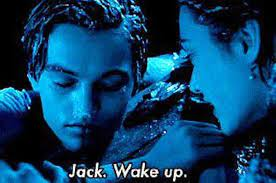

## Multilevel pivot tables
Just as in the GroupBy, the grouping in pivot tables can be specified with multiple lev‐
els, and via a number of options. For example, we might be interested in looking at
age as a third dimension. We’ll bin the age using the pd.cut function:

In [ ]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can apply this same strategy when working with the columns as well; let’s add info
on the fare paid using pd.qcut to automatically compute quantiles:

In [ ]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

# Be a Kaggle Master

https://www.kaggle.com/competitions/spaceship-titanic

# Working with Time Series
Pandas was developed in the context of financial modeling, so as you might expect, it
contains a fairly extensive set of tools for working with dates, times, and time-
indexed data. Date and time data comes in a few flavors, which we will discuss here:

• Time stamps reference particular moments in time (e.g., July 4th, 2015, at 7:00
a.m.).

• Time intervals and periods reference a length of time between a particular begin‐
ning and end point—for example, the year 2015. Periods usually reference a spe‐
cial case of time intervals in which each interval is of uniform length and does
not overlap (e.g., 24 hour-long periods constituting days).

• Time deltas or durations reference an exact length of time (e.g., a duration of
22.56 seconds).

In this section, we will introduce how to work with each of these types of date/time
data in Pandas. This short section is by no means a complete guide to the time series
tools available in Python or Pandas, but instead is intended as a broad overview of
how you as a user should approach working with time series. We will start with a
brief discussion of tools for dealing with dates and times in Python, before moving
more specifically to a discussion of the tools provided by Pandas. After listing some
resources that go into more depth, we will review some short examples of working
with time series data in Pandas.

## Dates and Times in Python
The Python world has a number of available representations of dates, times, deltas,
and timespans. While the time series tools provided by Pandas tend to be the most
useful for data science applications, it is helpful to see their relationship to other
packages used in Python.

### Native Python dates and times: datetime and dateutil
Python’s basic objects for working with dates and times reside in the built-in date
time module. Along with the third-party dateutil module, you can use it to quickly
perform a host of useful functionalities on dates and times. For example, you can
manually build a date using the datetime type:

In [ ]:
from datetime import datetime
datetime(year=2015, month=7, day=4)

datetime.datetime(2015, 7, 4, 0, 0)

Or, using the dateutil module, you can parse dates from a variety of string formats:

In [ ]:
from dateutil import parser
date = parser.parse("4th of July, 2015")
date

datetime.datetime(2015, 7, 4, 0, 0)

Once you have a datetime object, you can do things like printing the day of the week:

In [ ]:
date.strftime('%A')

'Saturday'

In [ ]:
! cal 2015

                            2015
      January               February               March          
Su Mo Tu We Th Fr Sa  Su Mo Tu We Th Fr Sa  Su Mo Tu We Th Fr Sa  
             1  2  3   1  2  3  4  5  6  7   1  2  3  4  5  6  7  
 4  5  6  7  8  9 10   8  9 10 11 12 13 14   8  9 10 11 12 13 14  
11 12 13 14 15 16 17  15 16 17 18 19 20 21  15 16 17 18 19 20 21  
18 19 20 21 22 23 24  22 23 24 25 26 27 28  22 23 24 25 26 27 28  
25 26 27 28 29 30 31                        29 30 31              
                                                                  

       April                  May                   June          
Su Mo Tu We Th Fr Sa  Su Mo Tu We Th Fr Sa  Su Mo Tu We Th Fr Sa  
          1  2  3  4                  1  2      1  2  3  4  5  6  
 5  6  7  8  9 10 11   3  4  5  6  7  8  9   7  8  9 10 11 12 13  
12 13 14 15 16 17 18  10 11 12 13 14 15 16  14 15 16 17 18 19 20  
19 20 21 22 23 24 25  17 18 19 20 21 22 23  21 22 23 24 25 26 27  
26 27 28 29 30        24 25 

In the final line, we’ve used one of the standard string format codes for printing dates
("%A"), which you can read about in the strftime section of Python’s datetime docu‐
mentation. Documentation of other useful date utilities can be found in dateutil’s
online documentation. A related package to be aware of is pytz, which contains tools
for working with the most migraine-inducing piece of time series data: time zones.
The power of datetime and dateutil lies in their flexibility and easy syntax: you can
use these objects and their built-in methods to easily perform nearly any operation
you might be interested in. Where they break down is when you wish to work with
large arrays of dates and times: just as lists of Python numerical variables are subopti‐
mal compared to NumPy-style typed numerical arrays, lists of Python datetime
objects are suboptimal compared to typed arrays of encoded dates.

Typed arrays of times: NumPy’s datetime64
The weaknesses of Python’s datetime format inspired the NumPy team to add a set of
native time series data type to NumPy. The datetime64 dtype encodes dates as 64-bit
integers, and thus allows arrays of dates to be represented very compactly. The date
time64 requires a very specific input format:

In [ ]:
date = np.array('2015-07-04', dtype=np.datetime64)
date

array('2015-07-04', dtype='datetime64[D]')

Once we have this date formatted, however, we can quickly do vectorized operations
on it:

In [ ]:
date + np.arange(12)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
       '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
      dtype='datetime64[D]')

One detail of the datetime64 and timedelta64 objects is that they are built on a fun‐
damental time unit. Because the datetime64 object is limited to 64-bit precision, the
range of encodable times is 264 times this fundamental unit. In other words, date
time64 imposes a trade-off between time resolution and maximum time span.
For example, if you want a time resolution of one nanosecond, you only have enough
information to encode a range of 264 nanoseconds, or just under 600 years. NumPy
will infer the desired unit from the input; for example, here is a day-based datetime:

In [ ]:
np.datetime64('2015-07-04')

numpy.datetime64('2015-07-04')

In [ ]:
np.datetime64('2015-07-04 12:00')

numpy.datetime64('2015-07-04T12:00')

Notice that the time zone is automatically set to the local time on the computer exe‐
cuting the code. You can force any desired fundamental unit using one of many for‐
mat codes; for example, here we’ll force a nanosecond-based time:

In [ ]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')

numpy.datetime64('2015-07-04T12:59:59.500000000')

## Dates and times in Pandas: Best of both worlds
Pandas builds upon all the tools just discussed to provide a Timestamp object, which
combines the ease of use of datetime and dateutil with the efficient storage and
vectorized interface of numpy.datetime64. From a group of these Timestamp objects,
Pandas can construct a DatetimeIndex that can be used to index data in a Series or
DataFrame; we’ll see many examples of this below.
For example, we can use Pandas tools to repeat the demonstration from above. We
can parse a flexibly formatted string date, and use format codes to output the day of
the week:

In [ ]:
date = pd.to_datetime("4th of July, 2015")
date

Timestamp('2015-07-04 00:00:00')

In [ ]:
date.strftime('%A')

'Saturday'

Additionally, we can do NumPy-style vectorized operations directly on this same
object:

In [ ]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

In the next section, we will take a closer look at manipulating time series data with
the tools provided by Pandas.
# Pandas Time Series: Indexing by Time
Where the Pandas time series tools really become useful is when you begin to index
data by timestamps. For example, we can construct a Series object that has time-
indexed data:

In [ ]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
'2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data

2014-07-04    0
2014-08-04    1
2015-07-04    2
2015-08-04    3
dtype: int64

Now that we have this data in a Series, we can make use of any of the Series index‐
ing patterns we discussed in previous sections, passing values that can be coerced into
dates:

In [ ]:
data['2014-07-04':'2015-07-04']

2014-07-04    0
2014-08-04    1
2015-07-04    2
dtype: int64

There are additional special date-only indexing operations, such as passing a year to
obtain a slice of all data from that year:

In [ ]:
data['2015']

2015-07-04    2
2015-08-04    3
dtype: int64

## Pandas Time Series Data Structures
This section will introduce the fundamental Pandas data structures for working with
time series data:

• For time stamps, Pandas provides the Timestamp type. As mentioned before, it is
essentially a replacement for Python’s native datetime, but is based on the more
efficient numpy.datetime64 data type. The associated index structure is
DatetimeIndex.
• For time periods, Pandas provides the Period type. This encodes a fixed-
frequency interval based on numpy.datetime64. The associated index structure is
PeriodIndex.
• For time deltas or durations, Pandas provides the Timedelta type. Timedelta is a
more efficient replacement for Python’s native datetime.timedelta type, and is
based on numpy.timedelta64. The associated index structure is TimedeltaIndex.

The most fundamental of these date/time objects are the Timestamp and DatetimeIn
dex objects. While these class objects can be invoked directly, it is more common to
use the pd.to_datetime() function, which can parse a wide variety of formats. Pass‐
ing a single date to pd.to_datetime() yields a Timestamp; passing a series of dates by
default yields a DatetimeIndex:

In [ ]:
dates = pd.to_datetime([datetime(2015, 7, 3), '4th of July, 2015',
'2015-Jul-6', '07-07-2015', '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

Any DatetimeIndex can be converted to a PeriodIndex with the to_period() function with the addition of a frequency code; here we’ll use 'D' to indicate daily frequency:

In [ ]:
dates.to_period('D')

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]')

A TimedeltaIndex is created, for example, when one date is subtracted from another:

In [ ]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

### Regular sequences: pd.date_range()
To make the creation of regular date sequences more convenient, Pandas offers a few
functions for this purpose: pd.date_range() for timestamps, pd.period_range() for
periods, and pd.timedelta_range() for time deltas. We’ve seen that Python’s range() and NumPy’s np.arange() turn a startpoint, endpoint, and optional stepsize
into a sequence. Similarly, pd.date_range() accepts a start date, an end date, and an
optional frequency code to create a regular sequence of dates. By default, the frequency is one day:

In [ ]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

Alternatively, the date range can be specified not with a start- and endpoint, but with
a startpoint and a number of periods:

In [ ]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

You can modify the spacing by altering the freq argument, which defaults to D. For
example, here we will construct a range of hourly timestamps:

In [ ]:
pd.date_range('2015-07-03', periods=8, freq='H')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

## Resampling, Shifting, and Windowing
The ability to use dates and times as indices to intuitively organize and access data is
an important piece of the Pandas time series tools. The benefits of indexed data in
general (automatic alignment during operations, intuitive data slicing and access,
etc.) still apply, and Pandas provides several additional time series–specific
operations.

We will take a look at a few of those here, using some stock price data as an example.
Because Pandas was developed largely in a finance context, it includes some very spe‐
cific tools for financial data. For example, the accompanying pandas-datareader
package (installable via conda install pandas-datareader) knows how to import financial data from a number of available sources.

In [ ]:
import pandas_datareader.data as data
from datetime import datetime, timedelta

from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
symbols = get_nasdaq_symbols()
symbols

,Nasdaq Traded,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
Symbol,,,,,,,,,,,
A,True,"Agilent Technologies, Inc. Common Stock",N,,False,100.0,False,NaN,A,A,False
AA,True,Alcoa Corporation Common Stock,N,,False,100.0,False,NaN,AA,AA,False
AAA,True,Listed Funds Trust AAF First Priority CLO Bond...,P,,True,100.0,False,NaN,AAA,AAA,False
AAAU,True,Goldman Sachs Physical Gold ETF Shares,Z,,True,100.0,False,NaN,AAAU,AAAU,False
AAC,True,Ares Acquisition Corporation Class A Ordinary ...,N,,False,100.0,False,NaN,AAC,AAC,False
...,...,...,...,...,...,...,...,...,...,...,...
ZXZZT,True,NASDAQ TEST STOCK,Q,G,False,100.0,True,N,NaN,ZXZZT,False
ZY,True,Zymergen Inc. - Common Stock,Q,Q,False,100.0,False,N,NaN,ZY,False
ZYME,True,Zymeworks Inc. Common Shares,N,,False,100.0,False,NaN,ZYME,ZYME,False


In [ ]:
tickers = 'GOOG'#['AMZN','MSFT','AAPL', 'FB']

In [ ]:
data_source = 'yahoo'
start = pd.to_datetime(['2007-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2021-12-31']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + tickers + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


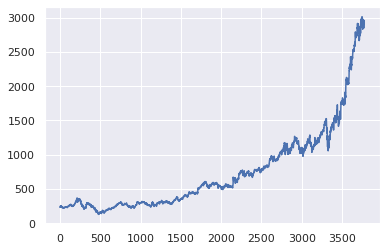

In [ ]:
df.Close.plot()

### Resampling and converting frequencies
One common need for time series data is resampling at a higher or lower frequency.
You can do this using the resample() method, or the much simpler asfreq()

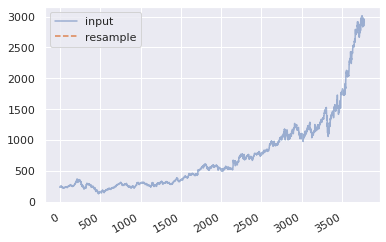

In [ ]:
goog=df.Close
goog.plot(alpha=0.5, style='-')
#goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
loc='upper left');

ERROR: Could not find a version that satisfies the requirement stock_analysis (from versions: none)
ERROR: No matching distribution found for stock_analysis
